# DQN Training for Grid World Environment
Deep Q-Network implementation using PyTorch

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
from GridEnv import create_grid_world, get_user_input

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## DQN Network Architecture

In [2]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

## Replay Buffer

In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards), 
                np.array(next_states), np.array(dones))
    
    def __len__(self):
        return len(self.buffer)

## Grid World Environment Wrapper

In [4]:
class GridWorldEnv:
    def __init__(self, height, width, obstacles, agent_pos, goal_pos):
        self.height = height
        self.width = width
        self.obstacles = obstacles
        self.start_pos = agent_pos
        self.goal_pos = goal_pos
        self.agent_pos = list(agent_pos)
        self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right
        
    def reset(self):
        self.agent_pos = list(self.start_pos)
        return self._get_state()
    
    def _get_state(self):
        state = np.zeros(self.height * self.width)
        state[self.agent_pos[0] * self.width + self.agent_pos[1]] = 1
        state[self.goal_pos[0] * self.width + self.goal_pos[1]] = 0.5
        for i in range(self.height):
            for j in range(self.width):
                if self.obstacles[i, j]:
                    state[i * self.width + j] = -1
        return state
    
    def step(self, action):
        dr, dc = self.actions[action]
        new_r = self.agent_pos[0] + dr
        new_c = self.agent_pos[1] + dc
        
        if 0 <= new_r < self.height and 0 <= new_c < self.width:
            if not self.obstacles[new_r, new_c]:
                self.agent_pos = [new_r, new_c]
        
        done = (tuple(self.agent_pos) == self.goal_pos)
        reward = 10 if done else -0.1
        
        return self._get_state(), reward, done

## DQN Agent

In [6]:
class DQNAgent:
    def __init__(self, state_size, action_size, lr=1e-3, gamma=0.99, 
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        self.policy_net = DQN(state_size, action_size).to(device)
        self.target_net = DQN(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = ReplayBuffer(10000)
        
    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_size)
        
        with torch.no_grad():
            state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = self.policy_net(state_t)
            return q_values.argmax().item()
    
    def train_step(self, batch_size):
        if len(self.memory) < batch_size:
            return 0
        
        states, actions, rewards, next_states, dones = self.memory.sample(batch_size)
        
        states_t = torch.FloatTensor(states).to(device)
        actions_t = torch.LongTensor(actions).to(device)
        rewards_t = torch.FloatTensor(rewards).to(device)
        next_states_t = torch.FloatTensor(next_states).to(device)
        dones_t = torch.FloatTensor(dones).to(device)
        
        q_values = self.policy_net(states_t).gather(1, actions_t.unsqueeze(1)).squeeze()
        
        with torch.no_grad():
            next_q_values = self.target_net(next_states_t).max(1)[0]
            target_q_values = rewards_t + (1 - dones_t) * self.gamma * next_q_values
        
        loss = nn.MSELoss()(q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

## Training Function

In [7]:
def train_dqn(env, episodes=500, batch_size=64, target_update=10):
    state_size = env.height * env.width
    action_size = 4
    agent = DQNAgent(state_size, action_size)
    
    rewards_history = []
    losses_history = []
    epsilon_history = []
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        total_loss = 0
        steps = 0
        
        for step in range(200):
            action = agent.select_action(state)
            next_state, reward, done = env.step(action)
            
            agent.memory.push(state, action, reward, next_state, done)
            loss = agent.train_step(batch_size)
            
            total_reward += reward
            total_loss += loss
            steps += 1
            state = next_state
            
            if done:
                break
        
        agent.decay_epsilon()
        
        if episode % target_update == 0:
            agent.update_target_network()
        
        rewards_history.append(total_reward)
        losses_history.append(total_loss / steps if steps > 0 else 0)
        epsilon_history.append(agent.epsilon)
        
        if episode % 50 == 0:
            avg_reward = np.mean(rewards_history[-50:])
            print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.3f}")
    
    return agent, rewards_history, losses_history, epsilon_history

## Plotting Function

In [8]:
def plot_training_results(rewards, losses, epsilons):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Rewards
    axes[0, 0].plot(rewards, alpha=0.3, label='Raw')
    axes[0, 0].plot(np.convolve(rewards, np.ones(50)/50, mode='valid'), label='Moving Avg (50)')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Total Reward')
    axes[0, 0].set_title('Training Rewards')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Losses
    axes[0, 1].plot(losses)
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Average Loss')
    axes[0, 1].set_title('Training Loss')
    axes[0, 1].grid(True)
    
    # Epsilon
    axes[1, 0].plot(epsilons)
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Epsilon')
    axes[1, 0].set_title('Exploration Rate (Epsilon)')
    axes[1, 0].grid(True)
    
    # Success rate
    window = 50
    success = [1 if r > 0 else 0 for r in rewards]
    success_rate = np.convolve(success, np.ones(window)/window, mode='valid')
    axes[1, 1].plot(success_rate)
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Success Rate')
    axes[1, 1].set_title(f'Success Rate (Moving Avg {window})')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

## Setup Environment

In [10]:
# Create grid world
config = get_user_input()
obstacles, agent_pos, goal_pos = create_grid_world(config)
env = GridWorldEnv(config['height'], config['width'], obstacles, agent_pos, goal_pos)

print("\nEnvironment created successfully!")
print(f"Grid size: {config['height']}x{config['width']}")
print(f"Agent start: {agent_pos}")
print(f"Goal position: {goal_pos}")

GRID WORLD CONFIGURATION

Obstacle placement:
1. Random
2. In a row
3. In a column
4. Specific position

Agent placement:
1. Random
2. Specific position

Goal placement:
1. Random
2. Specific position

Environment created successfully!
Grid size: 7x11
Agent start: (0, 0)
Goal position: (6, 10)


## Train DQN Agent

In [ ]:
agent, rewards, losses, epsilons = train_dqn(env, episodes=500)

print("\nTraining Complete!")
print(f"Final Average Reward (last 50 episodes): {np.mean(rewards[-50:]):.2f}")

Episode 0, Avg Reward: -20.00, Epsilon: 0.995
Episode 50, Avg Reward: -20.00, Epsilon: 0.774
Episode 100, Avg Reward: -20.00, Epsilon: 0.603
Episode 150, Avg Reward: -20.00, Epsilon: 0.469
Episode 200, Avg Reward: -20.00, Epsilon: 0.365
Episode 250, Avg Reward: -20.00, Epsilon: 0.284
Episode 300, Avg Reward: -20.00, Epsilon: 0.221
Episode 350, Avg Reward: -20.00, Epsilon: 0.172
Episode 400, Avg Reward: -20.00, Epsilon: 0.134


## Visualize Training Results

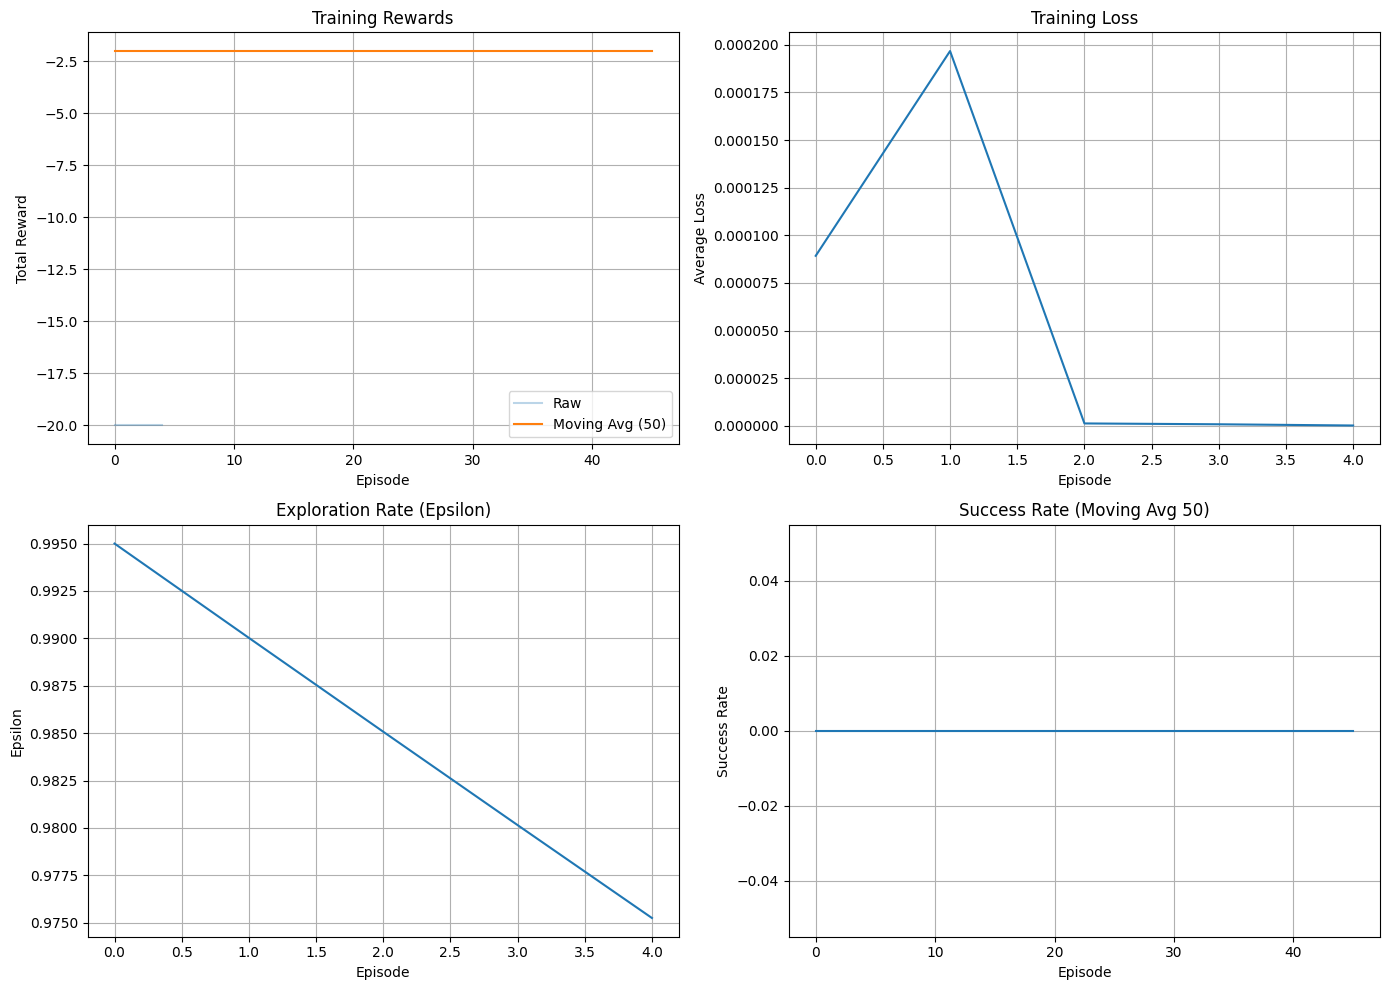

In [13]:
plot_training_results(rewards, losses, epsilons)

## Test Trained Agent

In [14]:
# Test the trained agent
state = env.reset()
total_reward = 0
steps = 0

print("Testing trained agent...")
for step in range(100):
    with torch.no_grad():
        state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = agent.policy_net(state_t).argmax().item()
    
    state, reward, done = env.step(action)
    total_reward += reward
    steps += 1
    
    if done:
        print(f"Goal reached in {steps} steps!")
        print(f"Total reward: {total_reward:.2f}")
        break

if not done:
    print(f"Did not reach goal in {steps} steps")

Testing trained agent...
Did not reach goal in 100 steps
